In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from image_helper import ImageHelper
from custom_image_dataset import CustomImageDataset
# from srcnn_model import SRCNN
import torchvision.models as models



/Users/pedrovelozo/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ImageHelperInstance = ImageHelper()

In [3]:
# Define the SRCNN model
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(
            in_channels=64, out_channels=32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(
            in_channels=32, out_channels=3, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.float()
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Define the training loop
def train_loop(dataloader: DataLoader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)

    running_loss = 0.0

    for batch, (X, y) in enumerate(dataloader):

        X = X.float()
        y = y.float()

        # Compute prediction and loss
        pred = model(X)

        loss = loss_fn(pred, y)

        running_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Epoch {epoch+1}, Batch {batch+1}/{len(dataloader)}, loss: {loss:>7f}, [{current:>5d}/{size:>5d}] ({100. * batch / len(dataloader):.0f}%)")

            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss / len(dataloader)
    

# Define the testing loop


def test_loop(model, test_loader, criterion, device):
    running_loss = 0.0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)

            outputs = model(X)

            loss = criterion(outputs, y)

            running_loss += loss.item()
    return running_loss / len(test_loader)


transform_x = transforms.Compose([
    # resize image to 33x33 and downsample by BICUBIC interpolation
    transforms.Resize((33, 33), interpolation=Image.BICUBIC),
    # resize image to 512x512
    transforms.Resize((256, 256), interpolation=Image.BICUBIC)
])

transform_y = transforms.Compose([
    # resize image to 512x512 and downsample by BICUBIC interpolation
    transforms.Resize((256, 256), interpolation=Image.BICUBIC),
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir="./datasets/DIV2K_train_HR/DIV2K_train_HR/", transform=transform_x, target_transform=transform_y)
test_data_set = CustomImageDataset(
    img_dir="./datasets/DIV2K_valid_HR/DIV2K_valid_HR/", transform=transform_x, target_transform=transform_y)
train_loader = DataLoader(train_data_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data_set, batch_size=16)

# Set up the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the SRCNN model, loss function, and optimizer
model = SRCNN().to(device)
criterion = nn.MSELoss()
learning_rate_1 = 1e-4 # for first 2 layers
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate_1)


/Users/pedrovelozo/anaconda3/lib/python3.10/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [4]:
# Train the model for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
    print(f'beginnig epoch {epoch}')
    train_loss = train_loop(train_loader, model, criterion, optimizer, epoch)
    test_loss = test_loop(model, test_loader, criterion, device)
    print(f'Epoch {epoch + 1}: Train Loss = {train_loss}, Test Loss = {test_loss}')
    print()

beginnig epoch 0


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<PIL.PngImagePlugin.PngImageFile image mode=RGB size=250x361 at 0x156A70070>


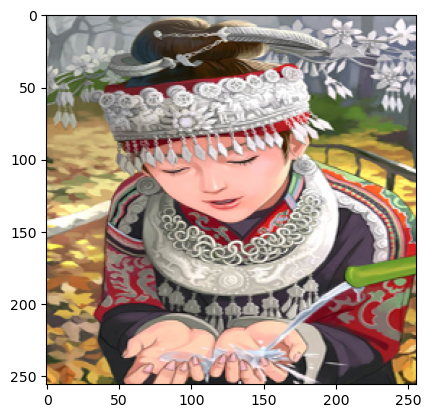

In [10]:
new_image = Image.open('./datasets/Set14/Set14/comic.png')
transform = transforms.Compose([transforms.ToTensor(),
                                # resize image to 512x512
                                transforms.Resize(
                                    (256, 256), interpolation=Image.BICUBIC)
                                ])
new_image_resize = transform(new_image)
print(new_image)
ImageHelperInstance.show_tensor_as_image(new_image_resize)

In [12]:
new_image_sr = model(new_image_resize)

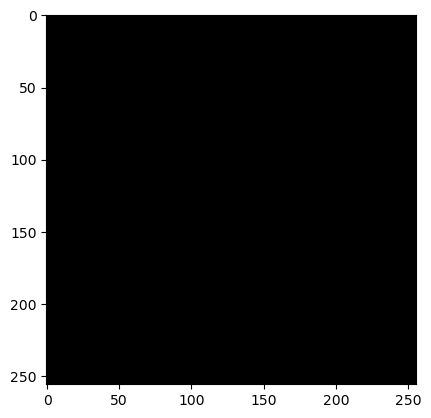

In [13]:
ImageHelperInstance.show_tensor_as_image(new_image_sr)

In [14]:
torch.save(model.state_dict(), './model_weights/model.pth')